In [1]:
import torch
from model import GuitarToneCloning
import torch.nn as nn
import torch.nn.functional as F


In [2]:
model = GuitarToneCloning().cuda()

In [153]:
import torch
import pickle
import sys
import types


model = torch.load('backup_20k',weights_only=False)
model_k0 = torch.load('flow_k0',weights_only=False).eval()

i=0

In [129]:
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim import Optimizer, AdamW
import math

class LinearWarmupCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, warmup_steps, total_steps, decay_factor=0.1, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.decay_factor = decay_factor

        self.base_lrs = [group['lr'] for group in optimizer.param_groups]
        self.min_lrs = [base_lr * decay_factor for base_lr in self.base_lrs]

        super(LinearWarmupCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_steps:
            return [
                base_lr * self.last_epoch / self.warmup_steps
                for base_lr in self.base_lrs
            ]
        else:
            progress = (self.last_epoch - self.warmup_steps) / (self.total_steps - self.warmup_steps)
            progress = min(max(progress, 0.0), 1.0)
            return [
                min_lr + (base_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
                for base_lr, min_lr in zip(self.base_lrs, self.min_lrs)
            ]


In [130]:

no_decay = ['bias', 'norm'] 
params = list(model.named_parameters())
for param in model.vocoder.parameters():
    param.requires_grad_(False)
for param in model.vocoder_disc.parameters():
    param.requires_grad_(False)

lr = 2e-4

optimizer_grouped_parameters = [
        {
  
        'params': [p for n, p in params if not any(nd in n for nd in no_decay)],
        'weight_decay': 0.001,
        'lr': lr
        },
        {
        'params': [p for n, p in params if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0,
        'lr': lr
        },
]
optimizer = AdamW(params=optimizer_grouped_parameters)
scheduler = LinearWarmupCosineAnnealingLR(optimizer=optimizer, warmup_steps=2000, total_steps=300000)

In [133]:
import torchaudio
import os
from utils import mel_spectrogram
sr=24000
frame_size=256
import torch
import torchaudio
import torchaudio.transforms as T
from itertools import product

import torch
import torchaudio
from itertools import product

import torch
import torchaudio

def augment_waveform(waveform, sample_rate, time_stretches, pitch_shifts):

    if waveform.dim() == 2 and waveform.size(0) > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    silence = torch.zeros((int(0.5 * sample_rate)))
    results = []

    for ts, ps in product(time_stretches, pitch_shifts):
        augmented = waveform.clone()
        if ts != 1.0:
            new_sr = int(sample_rate * ts)
            resample = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sr)
            augmented = resample(augmented)

        if ps != 0:
            pitch_shift = torchaudio.transforms.PitchShift(sample_rate=sample_rate, n_steps=ps)
            augmented = pitch_shift(augmented)
        results.append(augmented.detach())
        results.append(silence.detach())
    return torch.cat(results[:-1])



y_path="violin.wav"
x_path="clean_guitar.wav"


y=torchaudio.load(y_path)
y=torchaudio.functional.resample(y[0], y[1], sr)[0]

x=torchaudio.load(x_path)
x=torchaudio.functional.resample(x[0], x[1], sr)[0]


In [132]:
#"""
y = augment_waveform(y,sr, [1.1, 1.0, 0.9], [-2,-1,0,1,2])
import pickle
with open('cached_augmented.pkl','wb') as f:
    pickle.dump(y,f)
#"""

KeyboardInterrupt: 

In [134]:
import pickle
with open('cached_augmented.pkl','rb') as f:
    y = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'cached_augmented.pkl'

In [135]:
mel_y = mel_spectrogram(y.unsqueeze(0)).squeeze(0).T
mel_x = mel_spectrogram(x.unsqueeze(0)).squeeze(0).T

In [136]:
model.norm_params['mean'], model.norm_params['std'] = mel_y.mean().item(), mel_y.std().item()

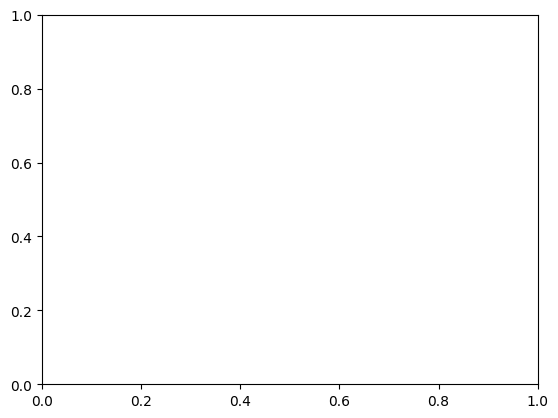

In [137]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import copy

plt.ion() 
fig, ax = plt.subplots()

flow = []
i=0

In [138]:
from torchdiffeq import odeint
rf=32
model.flow.last_h=None
model=model.cuda()
def train_unet(d1, raw_mels, optimizer):

    optimizer.zero_grad()
    raw_mels = model.mel_normalize(raw_mels)
    d1 = model.mel_normalize(d1)
    ########################
    #Train f_0
    ########################
    """
    t = torch.rand(raw_mels.shape[0],1,1, device=raw_mels.device)
    
    noise = torch.randn_like(raw_mels)
    noised_mels = t*raw_mels + (1-t)*noise

    
    v_pred = model.flow(noised_mels, t)
    v_target = raw_mels-noise
    """
    ########################
    #Rectify
    ########################
    coeff = 0.3
    steps = 30
    noise = torch.randn_like(raw_mels)
    noised_mels = coeff*raw_mels + (1-coeff)*noise
    
    
    with torch.no_grad():
        model_k0.flow.last_h = None
        
        @torch.inference_mode()
        def ode_func(t, x):
            print(t)
            t_batch = torch.ones(x.shape[0], 1, 1, device=x.device) * t
            return model_k0.flow(x, t_batch)
        
        t_span = torch.linspace(coeff, 1.0, steps=int(steps*(1-coeff))).to(raw_mels.device)
        
        trajectories = odeint(
            ode_func, 
            noised_mels.detach(), 
            t_span, 
            method='euler',
            options={'step_size': 1/steps}
        )
        z_refined = trajectories[-1]
        v_target = (z_refined - noise)
    ########################
    ########################
    #plt.matshow((noise[0][...,rf:]+v_target[0][...,rf:]).cpu().detach().numpy(),cmap='viridis')
    #plt.show()
    #input()
    
    t = torch.rand(raw_mels.shape[0],1,1, device=raw_mels.device)
    noised_mels = t*z_refined + (1-t)*noise
    v_pred = model.flow(noised_mels, t)
    loss_div = F.mse_loss(v_pred[...,rf:], v_target[...,rf:])

    print(v_pred[...,rf:].std().item())
    mean = F.interpolate(raw_mels.transpose(-1,-2), (10))
    restored_mean = model.mean_restoration(mean)
    loss_rest = F.mse_loss(restored_mean,mean)
    print('rest',loss_rest.item())
    
    (loss_div+loss_rest).backward()
    optimizer.step()

    return loss_div.item()
import random
import numpy as np
N=32
model.train()
while True:
    i+=1
    training_window = 384
    max_x = mel_x.shape[0]-training_window
    max_y = mel_y.shape[0]-training_window
    
    x_batch = []
    y_batch = []
    
    for _ in range(N):
        x_idx = random.randint(0, max_x)
        y_idx = random.randint(0, max_y)
        
        x_train = mel_x[x_idx:x_idx + training_window].clone().T.cuda().unsqueeze(0)
        y_train = mel_y[y_idx:y_idx + training_window].clone().T.cuda().unsqueeze(0)

        x_batch.append(x_train)
        y_batch.append(y_train)
    
    x_batch = torch.cat(x_batch, dim=0)
    y_batch = torch.cat(y_batch, dim=0)
    loss_flow = train_unet(x_batch,y_batch,optimizer)
    scheduler.step()
    flow.append(loss_flow)

    
    if i%10==0:
        clear_output(wait=True) 
        ax.clear()
        ax.plot(np.array(flow), label='flow')
        ax.legend()
        display(fig)
        torch.cuda.empty_cache()
    if i %1000 ==0:
        torch.save(model,'flow_k1_ckpt')

    

tensor(0.3000, device='cuda:0')
tensor(0.3333, device='cuda:0')
tensor(0.3667, device='cuda:0')
tensor(0.4000, device='cuda:0')
tensor(0.4333, device='cuda:0')
tensor(0.4667, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5333, device='cuda:0')
tensor(0.5667, device='cuda:0')
tensor(0.6000, device='cuda:0')
tensor(0.6333, device='cuda:0')
tensor(0.6667, device='cuda:0')
tensor(0.7000, device='cuda:0')
tensor(0.7333, device='cuda:0')
tensor(0.7667, device='cuda:0')
tensor(0.8000, device='cuda:0')
tensor(0.8333, device='cuda:0')
tensor(0.8667, device='cuda:0')
tensor(0.9000, device='cuda:0')
tensor(0.9333, device='cuda:0')
tensor(0.9667, device='cuda:0')
1.2273584604263306
rest 0.18101833760738373
tensor(0.3000, device='cuda:0')


KeyboardInterrupt: 

In [197]:
import torchvision
from torchdiffeq import odeint

window=32768*10
start=0#33607040#602352#33607040
mel_orig = mel_x[start//256:(start+window)//256].clone().cuda().unsqueeze(0)

mel_ = model.mel_normalize(mel_orig)
mean = F.interpolate(mel_, (10))
mean_corrected = model.mean_restoration(mean)
displacement = F.interpolate(mean_corrected - mean, (80),mode='linear')
mel_ += displacement
mel_ = mel_.transpose(-1,-2)




steps = 100
coeff=0.3
noise = torch.randn_like(mel_)
lat = mel_*coeff+noise*(1-coeff)
real = x[start:start+window]
"""
def ode_func(t, x):

    t_batch = torch.ones(x.shape[0], 1).to(x.device) * t  
    flow = model.flow(x, t_batch)
    print(flow.std(),flow.mean())
    return flow

t_span = torch.linspace(coeff, 1, steps)
with torch.no_grad():
    trajectories = odeint(
        ode_func, 
        lat.detach(), 
        t_span, 
        method='euler', 
        options={'step_size': 1/(steps)} 
    )
    out = trajectories[-1][...,rf:]
"""
#flow_ = model.flow(lat,torch.tensor([0]).cuda()) #flow = raw_mels-noise
model.flow.last_h=None
out = (model.flow(lat,torch.tensor([coeff]).cuda())+noise)[...,rf:]
#"""
waveform = model.vocoder(model.mel_denormalize(out)).flatten().cpu().detach()


[]

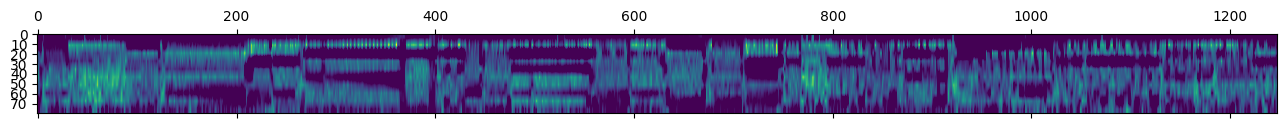

In [198]:
plt.matshow( F.interpolate(displacement.clip(min=0), (80),mode='linear').flip(1).cpu().detach().numpy()[0].T[...,rf:],cmap='viridis')
plt.plot()

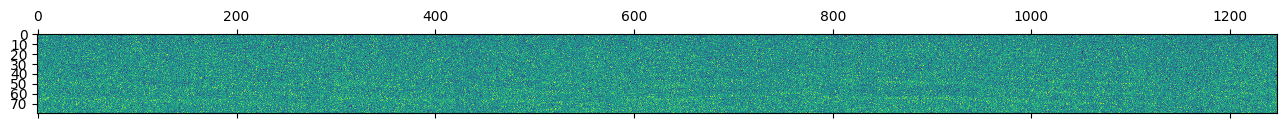

In [199]:
plt.matshow(lat[...,rf:].flip(1).cpu().detach().numpy()[0],cmap='viridis')


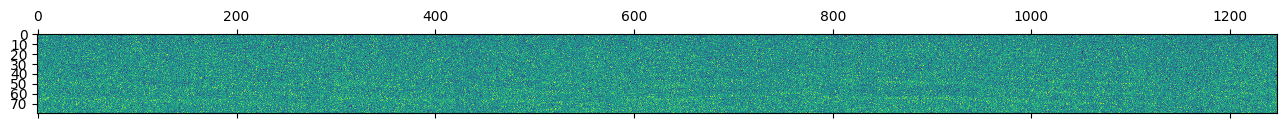

In [200]:
plt.matshow(lat[...,rf:].flip(1).cpu().detach().numpy()[0],cmap='viridis')


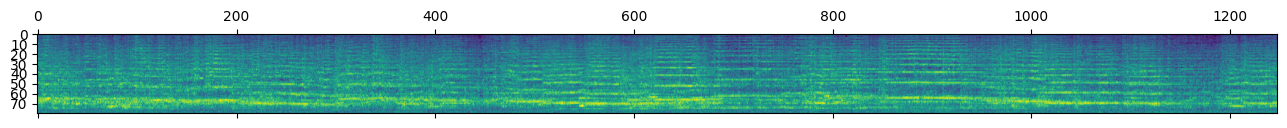

In [201]:
import sounddevice as sd
sd.play(waveform[rf*256:],sr)
plt.matshow(out.flip(1).cpu().detach().numpy()[0],cmap='viridis')


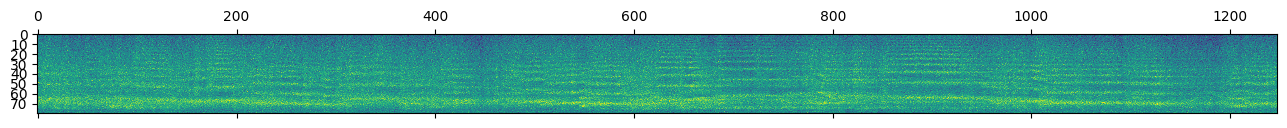

In [202]:
plt.matshow((out-lat[...,rf:]).flip(1).cpu().detach().numpy()[0],cmap='viridis')

[]

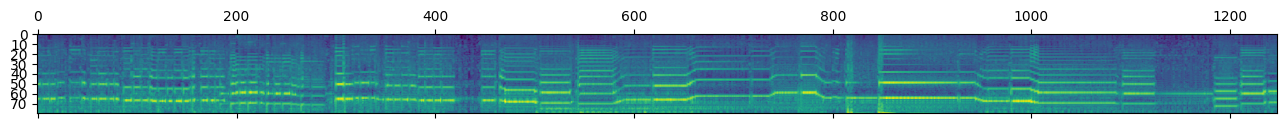

In [196]:
import sounddevice as sd
sd.play(real,sr)
plt.matshow(mel_[...,rf:].flip(1).cpu().detach().numpy()[0],cmap='viridis')
plt.plot()

In [34]:
naive = model.vocoder(model.mel_denormalize(mel_).cuda()).squeeze(0).squeeze(0).cpu().detach().numpy()
sd.play(naive,sr)

In [395]:
checkpoint = { 
    'epoch': i,
    'model': model,
    'optimizer': optimizer,
    'lr_sched': scheduler}
torch.save(checkpoint, f'checkpoint_unet{i}.pth')

In [235]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

1573

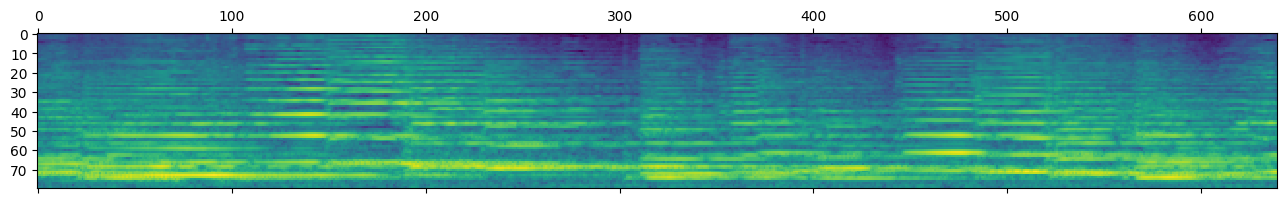

In [54]:
start,window=1800000,32768*5
mel_ = mel_y[start//256:(start+window)//256]
plt.matshow(mel_.flip(1).numpy().T,cmap='viridis')
plt.plot()
true = model.vocoder(mel_.cuda().unsqueeze(0).transpose(-1,-2)).squeeze(0).squeeze(0)
sd.play(true.cpu().detach().numpy(),sr)

In [47]:
sd.play(y[start:(start+window)],sr)

In [ ]:
modeltemp = torch.load('test7_unet',weights_only=False).cuda()
modeltemp.eval()
modeltemp.vocoder.turn_on_caching()
modeltemp.flow.turn_on_caching()
modeltemp.flow.last_h=None
fake2 = torch.tensor([],device='cuda')
fake2_mel= torch.tensor([],device='cuda').reshape(1,80,0)
with torch.no_grad():
    for chunk in mel_orig[0]:
        normalized = modeltemp.mel_normalize(chunk.cuda().unsqueeze(0).unsqueeze(2))
        noise = torch.randn_like(normalized)
        coeff=0.3
        lat = noise*(1-coeff)+coeff*normalized
        flow = modeltemp.flow(lat,torch.tensor([coeff]).cuda())
        out = flow+noise
        mel_guitar = modeltemp.mel_denormalize(out)
        print(mel_guitar.shape)
        fake2_mel = torch.cat((fake2_mel,mel_guitar),dim=-1)
        out=modeltemp.vocoder(mel_guitar).flatten()
        fake2 = torch.cat((fake2,out),dim=-1)

In [37]:
fake2=modeltemp.vocoder(fake2_mel).flatten()

In [68]:
sd.play(fake2[rf*256:].cpu().detach().numpy(),sr)

In [67]:
sd.play(waveform[rf*256:],sr)